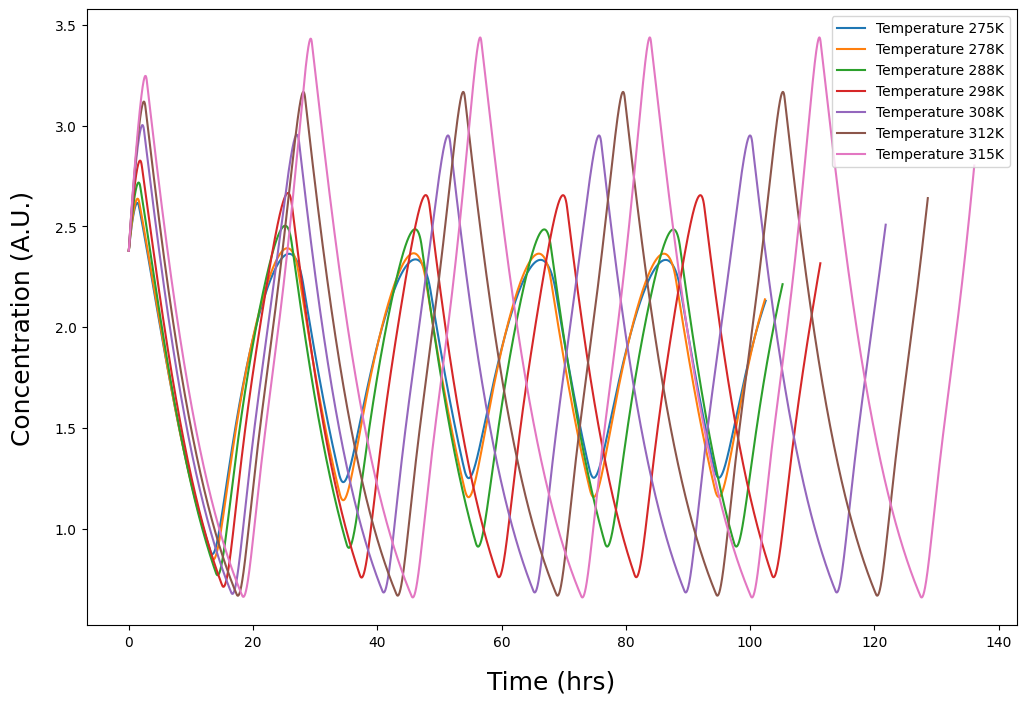

In [14]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def kaiABC_Rust(c, t, Temp):
    T = c[0]
    ST = c[1]
    S = c[2]

    KaiA = 1.3
    x = 298.15  # Temperature used for insensitive reactions

    # Parameters
    khalf = 383.83 * np.exp(-(16.8330449e3) / (8.3144598 * Temp))
    
    kUT0 = 0.0
    kUTA = 383.83 * np.exp(-(16.56527851e3) / (8.3144598 * Temp))
   
    kDT0 = 0.0
    kDTA = 383.83 * np.exp(-(19.08885839e3) / (8.3144598 * Temp))
   
    kTU0 = 383.83 * np.exp(-(18.60866545e3) / (8.3144598 * Temp))
    kTUA = 383.83 * np.exp(-(21.0046209e3) / (8.3144598 * Temp))
    
    kTD0 = 0.0
    kTDA = 383.83 * np.exp(-(18.5744178e3) / (8.3144598 * Temp))
   
    kSD0 = 0.0
    kSDA = 383.83 * np.exp(-(16.43132499e3) / (8.3144598 * Temp))
    
    kDS0 = 383.83 * np.exp(-(17.64373845e3) / (8.3144598 * x))
    kDSA = 383.83 * (-np.exp(-(17.56984493e3) / (8.3144598 * Temp)))
    
    kUS0 = 0.0
    kUSA = 383.83 * np.exp(-(22.00905957e3) / (8.3144598 * Temp))
    
    kSU0 = 383.83 * np.exp(-(20.21073081e3) / (8.3144598 * x))
    kSUA = 383.83 * (-np.exp(-(19.73888331e3) / (8.3144598 * Temp)))
    
    KaiC = 3.4

    U = max(0, KaiC - T - ST - S)
    A = max(0, 1.3 - 2. * S)

    # Parameters defined as function
    kUT = kUT0 + ((kUTA * A) / (khalf + A))
    kDT = kDT0 + ((kDTA * A) / (khalf + A))
    kTU = kTU0 + ((kTUA * A) / (khalf + A))
    kTD = kTD0 + ((kTDA * A) / (khalf + A))
    kSD = kSD0 + ((kSDA * A) / (khalf + A))
    kDS = kDS0 + ((kDSA * A) / (khalf + A))
    kUS = kUS0 + ((kUSA * A) / (khalf + A))
    kSU = kSU0 + ((kSUA * A) / (khalf + A))
    
    # Differential equations
    dTdt = (kUT * U + kDT * ST - kTU * T - kTD * T)
    dSTdt = (kTD * T + kSD * ST - kDT * ST - kDS * ST)
    dSdt = (kUS * U + kDS * ST - kSU * S - kSD * S)
    
    return [dTdt, dSTdt, dSdt]

def analyze_oscillator_with_plot(Temp, t0=0, tf=250, css=[0.68, 1.36, 0.34]):
    tspan = np.arange(t0, tf, 0.02)

    sol = odeint(kaiABC_Rust, css, tspan, args=(Temp,))
    T_val = sol[:, 0]
    ST_val = sol[:, 1]
    S_val = sol[:, 2]

    # Calculate total protein concentration over time
    total_protein = T_val + ST_val + S_val

    # Analyzing the amplitude and period of the total protein
    peaks, _ = find_peaks(total_protein)
    amplitudes = total_protein[peaks]

    if len(peaks) > 1:
        periods = np.diff(tspan[peaks])
        mean_period = np.mean(periods)
        # Adjust tf to show 5 periods
        tf = mean_period * 5
        tspan = np.arange(t0, tf, 0.02)
        sol = odeint(kaiABC_Rust, css, tspan, args=(Temp,))
        T_val = sol[:, 0]
        ST_val = sol[:, 1]
        S_val = sol[:, 2]
        total_protein = T_val + ST_val + S_val
    else:
        mean_period = np.nan

    mean_amplitude = np.mean(amplitudes)


    return tspan, total_protein, mean_period

# Temperatures to analyze
temperatures = [275, 278, 288, 298, 308, 312, 315]
mean_periods = []

# Plotting results for each temperature
plt.figure(figsize=(12, 8))

for Temp in temperatures:
    tspan, total_protein, mean_period = analyze_oscillator_with_plot(Temp)
    mean_periods.append(mean_period)
    plt.plot(tspan, total_protein, label=f'Temperature {Temp}K')

plt.xlabel('Time (hrs)', fontsize=18, labelpad=15)
plt.ylabel('Concentration (A.U.)', fontsize=18, labelpad=15)

plt.legend()
plt.show()

